#Diffusion Model

Sources:
- https://medium.com/@mickael.boillaud/denoising-diffusion-model-from-scratch-using-pytorch-658805d293b4
- https://theaisummer.com/diffusion-models/
- https://github.com/dome272/Diffusion-Models-pytorch

## DDPM

Notes:
- DDPM = Denoising Diffusion Probabilistic Model
- Initially proposed in a 2020 paper (https://arxiv.org/abs/2006.11239)
- Creates both diverse (VAE) and realistic (GAN) samples based on training data

Overview:
- Transforming a simple distribution (gaussian) through a series of diffusion steps can result in a complex data distribution (the opposite is true as well for transforming an image to be gaussian)
- Forward process: Fixed, non-learnable process to create noisy images
- Backward process: Use a ML model to denoise the image - The backward process uses a parameterized model because it cannot assume to know the final image, as with the forward pass.
- The optimization objective is the likelihood that the parameterized model produces and original image (x0), which comes from the training set

### Forward Process

- Over T steps, add a small amount of gaussian noise to the image from the previous step
- Uses Markov chain, so only the previous sample is needed - this allows for streamlined computations (simple equation can evaluate xt from xo if using a fixed variance schedule)
- 1000 forward steps were proposed in the paper (the variance parameter can be fixed, variable or learned over the time steps)

### Backward Process

- Need a function to denoise images, step by step, to generate the correct outcome
- In theory, it could learn to predict the mean of the distribution that is added in each diffusion step, but instead we try to predict only the noise added to the mean since the other components of the mean are constant
- The prediction is a function of the noisy image xt, and the timestep t (both inputs to the model)
- The optimization objective is to minimize the KL divergence between the forward (known) and backward (predicted) distributions at time t-1.

### Training and Sampling

- For each image in the dataset, randomly select a timestamp within the range [0, T] and compute the forward diffusion, yielding the original? image, the noisy image, and the applied noise
- Use U-net model and backpropagation to predict the noise given the noisy image
- KL divergence is used as the loss between the predicted and actual noise distributions (latent space will adhere to gaussian structure)
- To sample, start with a completely noisy image, then apply the backward process T times



### Model

- Uses the U-net model, which has inputs and outputs of the same size
- Uses ConvNext Block with encodes the time dimension (t) and adds to a CNN residual block

### Code

In [ ]:
%pip install einops
%pip install ema_pytorch

In [ ]:
import os
import math

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from ema_pytorch import EMA
from einops.layers.torch import Rearrange
from einops import rearrange

from matplotlib import pyplot as plt
from tqdm import tqdm
from pathlib import Path

import logging

In [ ]:
class ConvNextBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mult=2, time_embd_dim=None, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_embd_dim, in_channels))
            if time_embd_dim
            else None
        )

        self.in_conv = nn.Conv2d(
            in_channels, in_channels, 7, padding=3, groups=in_channels
        )

        self.block = nn.Sequential(
            nn.GroupNorm(1, in_channels) if norm else nn.Identity(),
            nn.Conv2d(in_channels, out_channels * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, out_channels * mult) if norm else nn.Identity(),
            nn.Conv2d(out_channels * mult, out_channels, 3, padding=1),
        )

        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, 1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, time_embedding=None):
        h = self.in_conv(x)
        if self.mlp is not None and time_embedding is not None:
            h = h + rearrange(self.mlp(time_embedding), "b c -> b c 1 1")
        h = self.block(h)
        return h + self.residual_conv(x)

In [ ]:
# Common positional encoding method
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta=10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [ ]:
# Performance improvement from down/up sampling
class DownSample(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.net = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
            nn.Conv2d(dim_in * 4, dim_out, 1),
        )

    def forward(self, x):
        return self.net(x)


class Upsample(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(dim_in, dim_out, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Multi-Layer Perceptron (MLP) for the time (t) input to each block
class TimeEmb(nn.Module):
    def __init__(self, dim, time_dim):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(dim, theta=10000),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

    def forward(self, x):
        return self.time_mlp(x)

In [ ]:
# Attention block between the residual connections and the upsampling half of the UNet to enhance the interaction
class BlockAttention(nn.Module):
    def __init__(self, gate_in_channel, residual_in_channel):
        super().__init__()
        self.gate_conv = nn.Conv2d(gate_in_channel, gate_in_channel, kernel_size=1, stride=1)
        self.residual_conv = nn.Conv2d(residual_in_channel, gate_in_channel, kernel_size=1, stride=1)
        self.in_conv = nn.Conv2d(gate_in_channel, 1, kernel_size=1, stride=1) # Add l/w?
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x) -> torch.Tensor:
        in_attention = self.relu(self.gate_conv(g) + self.residual_conv(x))
        in_attention = self.in_conv(in_attention)
        in_attention = self.sigmoid(in_attention)
        return in_attention * x

In [ ]:
class TwoResUNet(nn.Module):
    def __init__(self, dim=64, dim_mults=(1, 1, 2, 4, 8, 8), io_channels=3):
        super().__init__()
        self.io_channels = io_channels
        self.dim = dim
        self.init_conv = nn.Conv2d(io_channels, self.dim, 7, padding=3) # (128 + 2*3) - (7-1) = 128

        dims = [*map(lambda m: self.dim * m, dim_mults)] # (64, 64, 128, 256, 512, 512)
        in_out = list(zip(dims[:-1], dims[1:])) # [(a,b), (b,c), (c,d)]

        time_dim = dim * 4
        self.time_mlp = TimeEmb(dim, time_dim)

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out) - 1 # The first/last dim pair is excluded in the down/up paths

        for ind, (dim_in, dim_out) in enumerate(in_out[1:]):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        ConvNextBlock(
                            in_channels=dim_in,
                            out_channels=dim_in,
                            time_embd_dim=time_dim,
                        ),
                        ConvNextBlock(
                            in_channels=dim_in,
                            out_channels=dim_in,
                            time_embd_dim=time_dim,
                        ),
                        DownSample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        # Single mid block
        mid_dim = dims[-1]
        self.mid_block = ConvNextBlock(mid_dim, mid_dim, time_embd_dim=time_dim)

        for ind, (dim_out, dim_in) in enumerate(reversed(in_out[:-1])):
            is_last = ind == (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        ConvNextBlock(
                            in_channels=dim_in + dim_in, # Residual is concatenated
                            out_channels=dim_in,
                            time_embd_dim=time_dim,
                        ),
                        ConvNextBlock(
                            in_channels=dim_in + dim_in, # Residual is concatenated
                            out_channels=dim_in,
                            time_embd_dim=time_dim,
                        ),
                        Upsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                    ]
                )
            )

        self.final_res_block = ConvNextBlock(dim + dim, dim, time_embd_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, io_channels, 1)

    def forward(self, x, time):
        b, _, h, w = x.shape
        x = self.init_conv(x) # 3 channels -> 64 channels
        r = x.clone()

        t = self.time_mlp(time)

        unet_stack = []
        for down1, down2, downsample in self.downs:
            x = down1(x, t)
            unet_stack.append(x)
            x = down2(x, t)
            unet_stack.append(x)
            x = downsample(x)

        x = self.mid_block(x, t)

        for up1, up2, upsample in self.ups:
            x = torch.cat((x, unet_stack.pop()), dim=1)
            x = up1(x, t)
            x = torch.cat((x, unet_stack.pop()), dim=1)
            x = up2(x, t)
            x = upsample(x)

        x = torch.cat((x, r), dim=1)
        x = self.final_res_block(x, t)

        return self.final_conv(x)

# print(TwoResUNet())

In [ ]:
class AttentionUNet(nn.Module):
    def __init__(self, dim=64, dim_mults=(1, 1, 2, 4, 8, 8), io_channels=3, pos_emb_theta=10000):
        super().__init__()
        self.io_channels = io_channels
        self.dim = dim
        self.init_conv = nn.Conv2d(io_channels, self.dim, 7, padding=3) # (128 + 2*3) - (7-1) = 128

        dims = [*map(lambda m: self.dim * m, dim_mults)] # (64, 64, 128, 256, 512, 512)
        in_out = list(zip(dims[:-1], dims[1:])) # [(a,b), (b,c), (c,d)]

        time_dim = dim * 4
        self.time_mlp = TimeEmb(dim, time_dim)

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out) - 1 # The first/last dim pair is excluded in the down/up paths

        for ind, (dim_in, dim_out) in enumerate(in_out[1:]):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        ConvNextBlock(
                            in_channels=dim_in,
                            out_channels=dim_in,
                            time_embd_dim=time_dim,
                        ),
                        ConvNextBlock(
                            in_channels=dim_in,
                            out_channels=dim_in,
                            time_embd_dim=time_dim,
                        ),
                        DownSample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        # Single mid block
        mid_dim = dims[-1]
        self.mid_block = ConvNextBlock(mid_dim, mid_dim, time_embd_dim=time_dim)

        for ind, (dim_out, dim_in) in enumerate(reversed(in_out[:-1])):
            is_last = ind == (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        BlockAttention(dim_in, dim_in),
                        ConvNextBlock(
                            in_channels=dim_in + dim_in, # Residual is concatenated
                            out_channels=dim_in,
                            time_embd_dim=time_dim,
                        ),
                        ConvNextBlock(
                            in_channels=dim_in + dim_in, # Residual is concatenated
                            out_channels=dim_in,
                            time_embd_dim=time_dim,
                        ),
                        Upsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                    ]
                )
            )

        self.final_res_block = ConvNextBlock(dim + dim, dim, time_embd_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, io_channels, 1)

    def forward(self, x, time):
        b, _, h, w = x.shape
        x = self.init_conv(x) # 3 channels -> 64 channels
        r = x.clone()

        t = self.time_mlp(time)

        unet_stack = []
        for down1, down2, downsample in self.downs:
            x = down1(x, t)
            unet_stack.append(x)
            x = down2(x, t)
            unet_stack.append(x)
            x = downsample(x)

        x = self.mid_block(x, t)

        for attn, up1, up2, upsample in self.ups:
            attn_out = attn(x, unet_stack.pop())
            x = torch.cat((x, attn_out), dim=1)
            x = up1(x, t)
            attn_out = attn(x, unet_stack.pop()) # Use different attention block?
            x = torch.cat((x, attn_out), dim=1)
            x = up2(x, t)
            x = upsample(x)

        x = torch.cat((x, r), dim=1)
        x = self.final_res_block(x, t)

        return self.final_conv(x)

# print(AttentionUNet())

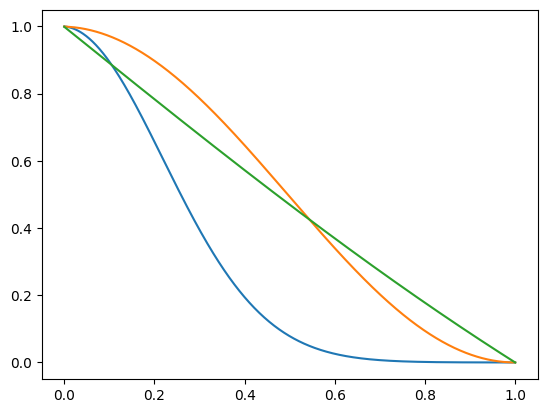

In [ ]:
# Beta setting approaches
def linear_beta_schedule(timesteps: int) -> torch.Tensor:
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)


def cosine_beta_schedule(timesteps: int, s: float = 0.008) -> torch.Tensor:
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def sigmoid_beta_schedule(
    timesteps: int, start: int = 0, end: int = 1, tau: int = 1
) -> torch.Tensor:
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (
        v_end - v_start
    )
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

ts = 1000
time = torch.linspace(0, 1, ts)
betas_lin = linear_beta_schedule(ts)
alphas_cumprod_lin = torch.cumprod(1-betas_lin, dim=0)
plt.plot(time, alphas_cumprod_lin)

betas_cos = cosine_beta_schedule(ts)
alphas_cumprod_cos = torch.cumprod(1-betas_cos, dim=0)
plt.plot(time, alphas_cumprod_cos)

betas_sig = sigmoid_beta_schedule(ts)
alphas_cumprod_sig = torch.cumprod(1-betas_sig, dim=0)
plt.plot(time, alphas_cumprod_sig)
plt.show()

In [ ]:
def normalize_to_neg_one_to_one(img: torch.Tensor) -> torch.Tensor:
    return img * 2 - 1


def unnormalize_to_zero_to_one(img: torch.Tensor) -> torch.Tensor:
    return (img + 1) * 0.5

In [ ]:
from torch.functional import F
from tqdm import tqdm

class DiffusionModel(nn.Module):
    SCHEDULER_MAPPING = {
        "linear": linear_beta_schedule,
        "cosine": cosine_beta_schedule,
        "sigmoid": sigmoid_beta_schedule,
    }

    def __init__(self, model, image_size, beta_scheduler="linear", timesteps=1000, schedule_fn_kwargs=None, device="cuda"):
        super().__init__()
        self.model = model
        self.image_size = image_size
        self.device = device
        self.io_channels = model.io_channels

        self.beta_scheduler_fn = self.SCHEDULER_MAPPING.get(beta_scheduler)
        if self.beta_scheduler_fn is None:
            raise ValueError(f"unknown beta schedule {beta_scheduler}")

        if schedule_fn_kwargs is None:
            schedule_fn_kwargs = {}

        # Calculate posterior variance - total noise variance at time t
        betas = self.beta_scheduler_fn(timesteps, **schedule_fn_kwargs)[:,None,None,None]
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

        self.num_timesteps = int(timesteps)

        self.normalize = normalize_to_neg_one_to_one
        self.unnormalize = unnormalize_to_zero_to_one


    @torch.inference_mode()
    def p_sample(self, x: torch.Tensor, t: int) -> torch.Tensor:
        b, *_, device = *x.shape, x.device
        batched_t = torch.full(
            (b,), t, device=device, dtype=torch.long
        )

        preds = self.model(x, batched_t)

        predicted_mean = 1/torch.sqrt(self.alphas[t]) * (
            x - self.betas[t] * preds / torch.sqrt(1-self.alphas[t])
        )

        if t == 0:
            return predicted_mean
        else:
            noise = torch.randn_like(x)
            return predicted_mean + torch.sqrt(self.betas[t]) * noise


    @torch.inference_mode()
    def p_sample_loop(self, shape: tuple, return_all_timesteps: bool = False) -> torch.Tensor:
        batch = shape[0]
        img = torch.randn(shape, device=self.device)
        imgs = [img]

        for t in tqdm(reversed(range(0, self.num_timesteps)), total=self.num_timesteps):
            img = self.p_sample(img, t)
            if return_all_timesteps:
                imgs.append(img)

        ret = img if not return_all_timesteps else torch.stack(imgs, dim=1)

        ret = self.unnormalize(ret)
        return ret


    def sample(self, batch_size: int = 16, return_all_timesteps: bool = False) -> torch.Tensor:
        shape = (batch_size, self.io_channels, self.image_size, self.image_size)
        return self.p_sample_loop(shape, return_all_timesteps=return_all_timesteps)

    def q_sample(self, x, t):
        noise = torch.randn_like(x)
        x_t = torch.sqrt(self.alphas_cumprod[t]) * x + torch.sqrt(1 - self.alphas_cumprod[t]) * noise
        return x_t, noise

    def p_loss(self, x, loss_type: str = "l2") -> torch.Tensor:
        t = torch.randint(1, self.num_timesteps, (x.shape[0],)).to(x.device)
        x_t, noise = self.q_sample(x, t)
        predicted_noise = self.model(x_t, t)

        if loss_type == "l2":
            loss = F.mse_loss(noise, predicted_noise)
        elif loss_type == "l1":
            loss = F.l1_loss(noise, predicted_noise)
        else:
            raise ValueError(f"unknown loss type {loss_type}")
        return loss

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        assert h == w == self.image_size, f"image size must be {self.img_image_sizesize}"
        return self.p_loss(x)

In [ ]:
# Setup
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Root directory for dataset
dataroot = "./data"

# Number of workers for dataloader
workers = 1

# Spatial size of training images. All images will be resized to this size using a transform.
image_size = 8

# Batch size for training
batch_size = 16

# Number of channels in the training images. For color images this is 3
nc = 1

# Base dimention of the UNet channels
dim = 4

# The number and magnitude of UNet scaling steps
dim_mults = (1, 1, 2, 4, 4)

# Diffusion noise steps
timesteps = 100

# Number of training epochs
num_epochs = 2

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

torch.Size([16, 1, 8, 8])


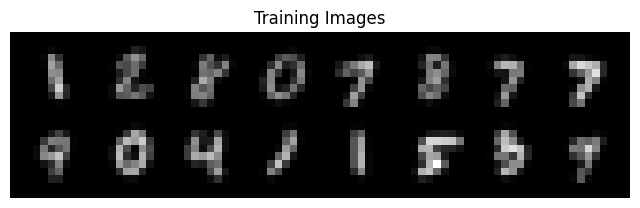

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.Resize(image_size),
         transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
        ])
    out_dir = './dataset'
    return dset.MNIST(root=out_dir, train=True, transform=compose, download=True)

data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Plot some training images
real_batch = next(iter(data_loader))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Files already downloaded and verified


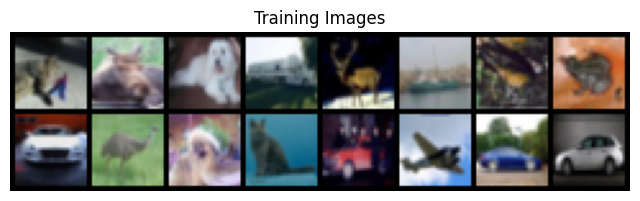

In [ ]:
# Data loading
dataset = dset.CIFAR10(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]),
                       download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
unet = TwoResUNet(dim, dim_mults, nc)
model = DiffusionModel(unet, image_size, beta_scheduler="cosine", timesteps=timesteps, device=device)

torch.Size([8, 1, 8, 8])


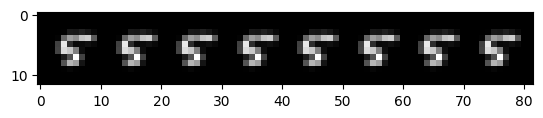

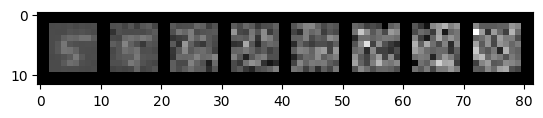

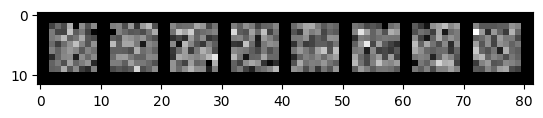

In [ ]:
test_img = next(iter(data_loader))[0][0]

x_0 = test_img.repeat(8,1,1,1)
print(x_0.size())
plt.imshow(np.transpose(vutils.make_grid(x_0.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

t = torch.linspace(0, timesteps - 1, 8, dtype=int)
x_t, noise = model.q_sample(x_0, t)

plt.imshow(np.transpose(vutils.make_grid(x_t.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.imshow(np.transpose(vutils.make_grid(noise.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


loss: 0.1513:   0%|          | 2/3125 [02:18<60:15:10, 69.46s/it]

100%|██████████| 100/100 [00:01<00:00, 61.89it/s]


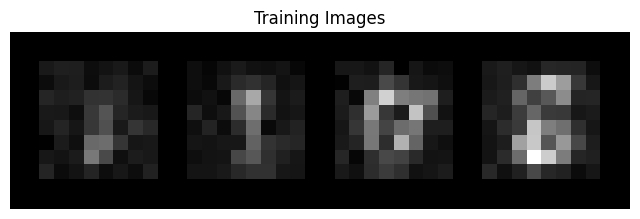

100%|██████████| 100/100 [00:02<00:00, 44.14it/s]


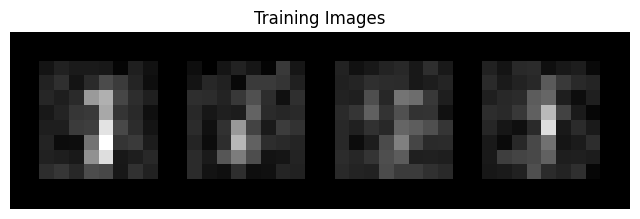

100%|██████████| 100/100 [00:01<00:00, 63.54it/s]


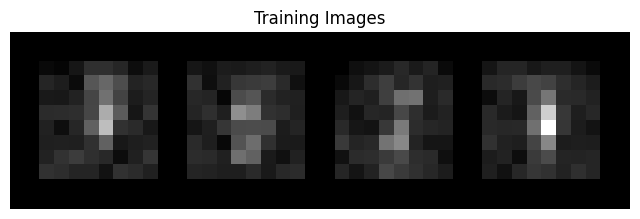

100%|██████████| 100/100 [00:01<00:00, 70.14it/s]


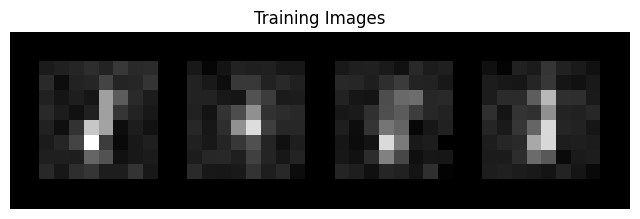


100%|██████████| 100/100 [00:01<00:00, 68.04it/s]


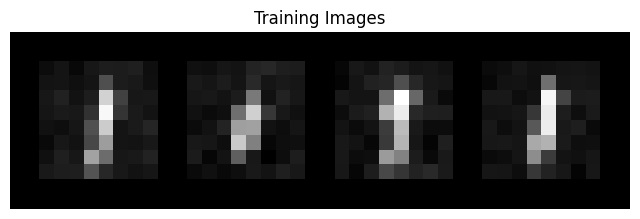


100%|██████████| 100/100 [00:01<00:00, 67.85it/s]


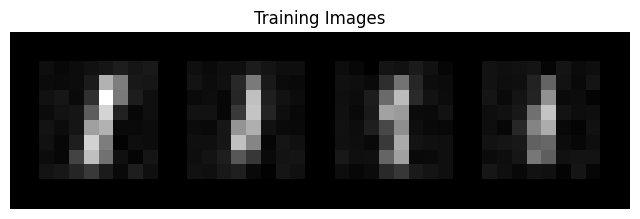


100%|██████████| 100/100 [00:01<00:00, 68.69it/s]


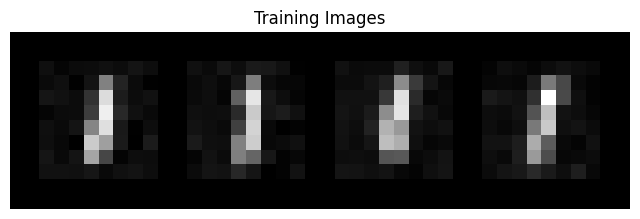


loss: 0.0971:   0%|          | 4/3125 [05:13<67:53:25, 78.31s/it]

100%|██████████| 100/100 [00:01<00:00, 60.31it/s]


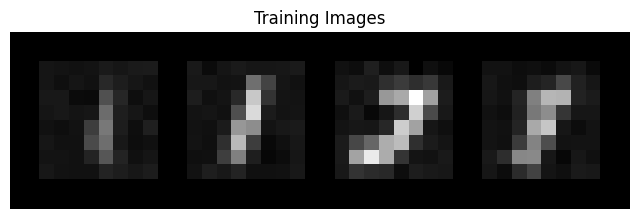

100%|██████████| 100/100 [00:01<00:00, 61.58it/s]


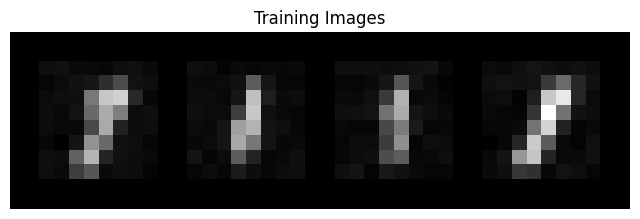

100%|██████████| 100/100 [00:02<00:00, 38.78it/s]


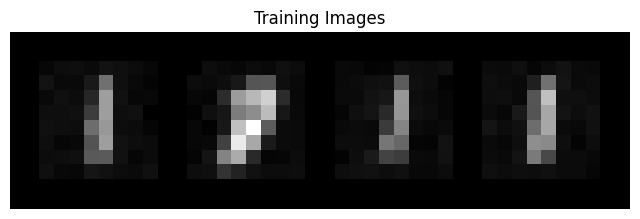

100%|██████████| 100/100 [00:01<00:00, 62.54it/s]


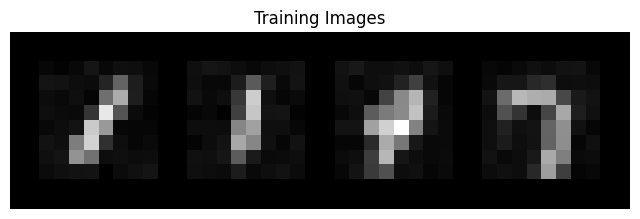

100%|██████████| 100/100 [00:01<00:00, 68.55it/s]


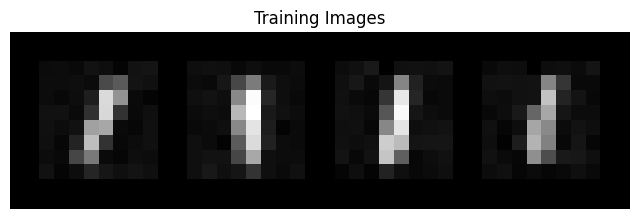


100%|██████████| 100/100 [00:01<00:00, 68.73it/s]


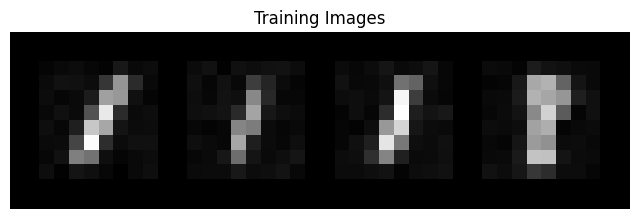


100%|██████████| 100/100 [00:02<00:00, 44.90it/s]


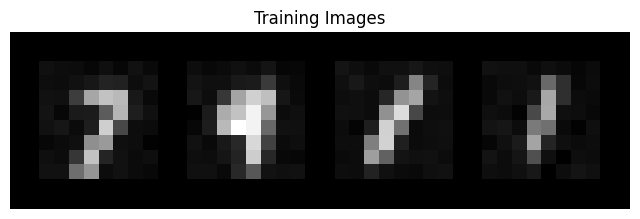


100%|██████████| 100/100 [00:01<00:00, 67.95it/s]


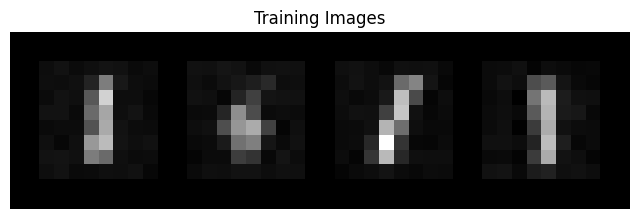


loss: 0.1801:   0%|          | 4/3125 [05:13<67:59:32, 78.43s/it]

100%|██████████| 100/100 [00:01<00:00, 62.38it/s]


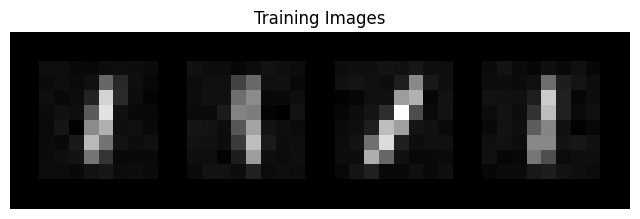

100%|██████████| 100/100 [00:01<00:00, 60.50it/s]


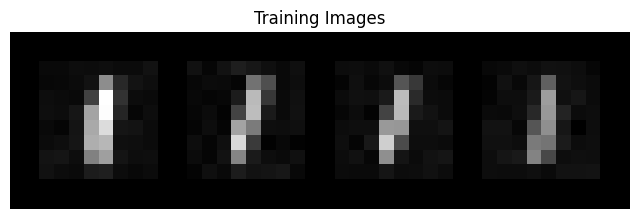

100%|██████████| 100/100 [00:02<00:00, 42.48it/s]


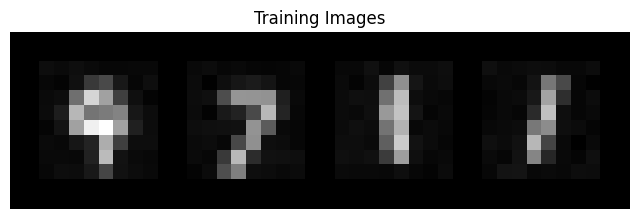

loss: 0.0931:   0%|          | 3/3125 [04:10<72:34:26, 83.69s/it]

In [ ]:
learning_rate = 1e-3
num_epochs = 5

adam_betas = (0.9, 0.99)
opt = optim.AdamW(model.parameters(), lr=learning_rate, betas=adam_betas)

ema_update_every = 10
ema_decay = 0.995
ema = EMA(model, beta=ema_decay, update_every=ema_update_every)
ema.to(device)

save_and_sample_every = 1000
num_samples = 4
save_models = False
results_folder = Path("./diffusion_results")
results_folder.mkdir(exist_ok=True)

step = 0
total_loss = 0.0

def save(milestone: int) -> None:
    data = {
        "step": step,
        "model": model.model.state_dict(),
        "opt": opt.state_dict(),
        "ema": ema.state_dict(),
        "version": "1.0",
    }

    torch.save(data, str(results_folder / f"model-{milestone}.pt"))


def load(milestone: int, is_old_model: bool = False) -> None:
    data = torch.load(
        str(results_folder / f"model-{milestone}.pt"),
        map_location=device,
    )

    model.model.load_state_dict(data["model"])

    step = data["step"]
    opt.load_state_dict(data["opt"])
    ema.load_state_dict(data["ema"])

    if "version" in data:
        print(f"loading from version {data['version']}")


for epoch in range(num_epochs):
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(dataloader)
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)

        loss = model(images)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

        step += 1
        ema.update()

        if step % save_and_sample_every == 0:
            ema.ema_model.eval()

            with torch.inference_mode():
                milestone = step // save_and_sample_every
                sampled_imgs = ema.ema_model.sample(batch_size=num_samples)

            for ix, sampled_img in enumerate(sampled_imgs):
                vutils.save_image(
                    sampled_img,
                    str(results_folder / f"sample-{milestone}-{ix}.png"),
                )

            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("Training Images")
            plt.imshow(np.transpose(vutils.make_grid(sampled_imgs.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()

            if save_models:
                save(milestone)

            pbar.set_description(f"loss: {loss.item():.4f}")
            pbar.update(1)